In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imripy
from imripy import merger_system as ms
from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from numpy import diff

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})



π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
t_m = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr
yr = 3.154e7              # in units of seconds
t_eq = 1.59246e12/yr      # in units of yr
M_solar = 1.989e30


# Definition of the binary system 


m_1 = 1e-3   #in units of M☉
m_2 = 2*m_1   #in units of M☉

y_1 = np.log(m_1)
y_2 = np.log(m_2)
dy  = (y_2 - y_1)

print("dy=",dy)

y_list = np.zeros(20)
m_1_list = np.zeros(len(y_list))
m_2_list = np.zeros(len(y_list))

for i in range(len(y_list)):
    m_1_list[i] = m_2_list[i] = (m_1 + ((i/4)*np.exp(dy)))

Δ_1_list = np.zeros(len(y_list))
Δ_2_list = np.zeros(len(y_list))

for i, m_1 in enumerate(m_1_list):
    Δ_1_list[i] =  Δ_2_list[i] = np.exp(m_1 + 0.5*dy) - np.exp(m_1 - 0.5*dy)
     

    

    
def a(m_1,m_2,Δ_1,Δ_2):  # for x = x_bar 
    
    f_pbh = 4.3e-3
    f = 0.85 * f_pbh
        
          
    def P(m): #Powerlaw PBH mass distribution
        α = 1.6
        M = 1e-4     #in units of M☉
        return ((α-1)/M) * ((m/M)**(-α))

    
    def f_(m):
        return f*P(m)
    
    def f_b(m_1,m_2):
        return  f_(m_1)+f_(m_2)
    
    def x̄(m_1,m_2,Δ_1,Δ_2):
        return (((3*(m_1+m_2))/(8*π*ρ_eq*f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2)))**(1/3))
   
    def λ(m_1,m_2,Δ_1,Δ_2):
        return (8*π*ρ_eq*(x̄(m_1,m_2,Δ_1,Δ_2)**3))/(3*(m_1 + m_2))

    
    return ( 0.0977*λ(m_1,m_2,Δ_1,Δ_2) + 0.0057*(λ(m_1,m_2,Δ_1,Δ_2)**2) ) * x̄(m_1,m_2,Δ_1,Δ_2)





a_initial = a(m_1_list[2], m_2_list[0], Δ_1_list[2], Δ_2_list[0])


print("a_initial= ", a_initial)


# Setting initial and final conditions of the binary evolution for an eccentric orbit
a_i_ref = a_initial * 1e9
j0_array = np.geomspace(1e-4, 1, 10)
j0_ref_list = j0_array.tolist()





plt.figure(figsize = (10, 5))
plt.rc('lines', linewidth=1)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(which='both', right=True, top=True)






tm_ref_list = np.zeros(len(j0_ref_list))
T_list = np.zeros(len(j0_ref_list))


for k, j0 in enumerate (j0_ref_list):
    m_bar = 1
    m1 =  m_bar * ms.solar_mass_to_pc  
    m2 = 1e-3 * ms.solar_mass_to_pc   
    D_luminosity = 5e8              
    ρ_bar = (ρ_eq/2) * (t_eq**(3/2)) * ((2 * G * m_bar)**(3/4))   
    r_spike = 1  # in parsecs, Choosen by choice
    alpha = 9/4
    rho_spike =  ρ_bar * (r_spike**(-alpha)) * ms.solar_mass_to_pc  
    spike = imripy.halo.Spike(rho_spike, r_spike, alpha)
    sp = ms.SystemProp(m1, m2, spike, D_luminosity)
    a_fin = sp.r_isco()      # Choosen equal to r_icso
    R_fin = sp.r_isco()      # The final condition for the evolution
    e0 = np.sqrt(1 -(j0**2))
    
    
    m_2_ref = 1 # in units of solar mass
    T = 1e-6 * (t_m * ms.year_to_pc ) * ((m2/m_2_ref)**(-1))
    
    ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i_ref , e0,  a_fin = R_fin, t_fin = T)
    tm = ev_ecc.t[-1]
    
    
    while np.isclose(T, tm) == True: 
        T = T * 1e-3
        ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i, e0,  a_fin = R_fin, t_fin = T)
        tm = ev_ecc.t[-1]
        
            
            
    tm_ref_list[k] = tm/ms.year_to_pc
    T_list[k] =  T/ms.year_to_pc
      
    
   
   
    
    np.savez("tmofjo",  j0_ref_list,  tm_ref_list)

    
    
plt.loglog(j0_ref_list, tm_ref_list, '--o')
plt.loglog(j0_ref_list, T_list, 'r')


print(tm_ref_list)
    

plt.xlabel('$j_{i}$', fontsize = 13)
plt.ylabel('final merger time / yr', fontsize = 12)
plt.title('$m_{1} = 1 \, M_{\odot}$ and $m_{2}= 10^{-3} \,  M_{\odot}$ ')
plt.grid()
plt.show()

dy= 0.6931471805599454
a_initial=  0.00643464971052437
Evolving from  2.234253371709851e+19  to  1.0 r_isco  with initial eccentricity 0.9999999949999999  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08


/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/inspiral.py:534: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  t_coal = t_coal * 48./19. / g(e_0)**4 * quad(lambda e: g(e)**4 *(1-e**2)**(5./2.) /e/(1. + 121./304. * e**2), 0., e_0, limit=100)[0]   # The inspiral time according to Maggiore (2007)
/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/inspiral.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  return 4.*np.pi * sp.m2**2 * sp.halo.density(r) * Classic.dmPhaseSpaceFraction * ln_Lambda / v**2
/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/inspiral.py:336: RuntimeWarning: invalid value encountered in double_scalars
  return F(sp, r, v_s, opt)*v_s / (1.+e*np.cos(phi))**2
/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/inspiral.py:337: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimate

Evolving from  22342533717098.508  to  1.0 r_isco  with initial eccentricity 1.0  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08


ValueError: `max_step` must be positive.

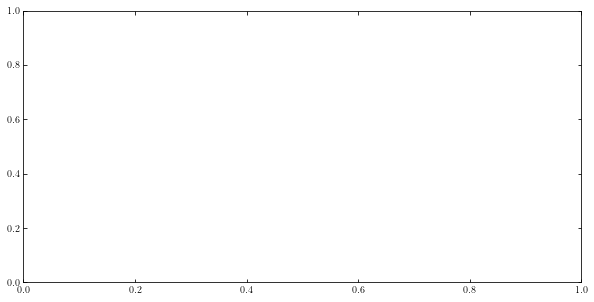

In [7]:
# Setting initial and final conditions of the binary evolution for an eccentric orbit
a_i_ref = a_initial * 1e3

j0_array = np.geomspace(1e-4, 1, 10)
j0_ref2_list = j0_array.tolist()




plt.figure(figsize = (10, 5))
plt.rc('lines', linewidth=1)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(which ='both', right = True, top = +True)





j0_ref2_list = np.zeros(len(e0_list))
tm_ref2_list = np.zeros(len(e0_list))


for k, j0 in enumerate (j0_ref2_list):
    m_bar = 1
    m1 =  m_bar * ms.solar_mass_to_pc  
    m2 = 1e-3 * ms.solar_mass_to_pc   
    D_luminosity = 5e8              
    ρ_bar = (ρ_eq/2) * (t_eq**(3/2)) * ((2 * G * m_bar)**(3/4))   
    r_spike = 1  # in parsecs, Choosen by choice
    alpha = 9/4
    rho_spike =  ρ_bar * (r_spike**(-alpha)) * ms.solar_mass_to_pc  
    spike = imripy.halo.Spike(rho_spike, r_spike, alpha)
    sp = ms.SystemProp(m1, m2, spike, D_luminosity)
    a_fin = sp.r_isco()      # Choosen equal to r_icso
    R_fin = sp.r_isco()      # The final condition for the evolution
    
    e0 = np.sqrt(1 -(j0**2))
    ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i_ref , e0,  a_fin = R_fin)
    tm_ref2_list[k] = ev_ecc.t[-1]/ms.year_to_pc
    np.save("tm2_ref",  tm_ref2_list)
    
plt.loglog(j0_ref2_list, tm_ref2_list, '--o')
    

print(tm_ref2_list)
    

plt.xlabel('$j_{i}$', fontsize = 13)
plt.ylabel('final merger time / yr', fontsize = 12)
plt.title('$m_{1} = 1 \, M_{\odot}$ and $m_{2}= 10^{-3} \,  M_{\odot}$ ')
plt.grid()
plt.show()

Evolving from  2.2342533717098506e+21  to  1.0 r_isco  with initial eccentricity 0.99999  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08


/home/pratibhajangra/imripy/src/imripy/inspiral.py:335: RuntimeWarning: invalid value encountered in sqrt
  v_s = np.sqrt(sp.m_total(a) *(2./r - 1./a))
/home/pratibhajangra/imripy/src/imripy/halo.py:321: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(r > self.r_min, self.rho_spike * (self.r_spike/r)**self.alpha, 0.)
/home/pratibhajangra/imripy/src/imripy/inspiral.py:337: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/home/pratibhajangra/imripy/src/imripy/inspiral.py:172: RuntimeWarning: invalid value encountered in double_scalars
  return -32./5. * sp.m_reduced(a)**2 * sp.m_total(a)**(5./2.) / a**(7./2.)  / (1. - e**2)**2 * (1. + 7./8.*e**2)
/home/pratibhajangra/imripy/src/imripy/inspiral.py:361: RuntimeWarning: invalid value encountered in sqrt
  retur

Required step size is less than spacing between numbers.
 -> Evolution took 3.2917s
Evolving from  2.2342533717098506e+21  to  1.0 r_isco  with initial eccentricity 0.9999897072522759  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08


/home/pratibhajangra/imripy/src/imripy/inspiral.py:153: RuntimeWarning: invalid value encountered in double_scalars
  return -32./5. * sp.m_reduced(a)**2 * sp.m_total(a)**3 / a**5  / (1. - e**2)**(7./2.) * (1. + 73./24. * e**2 + 37./96. * e**4)
/home/pratibhajangra/imripy/src/imripy/inspiral.py:337: RuntimeWarning: invalid value encountered in double_scalars
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/home/pratibhajangra/imripy/src/imripy/inspiral.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total(a) * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]


Required step size is less than spacing between numbers.
 -> Evolution took 3.4527s
Evolving from  2.2342533717098506e+21  to  1.0 r_isco  with initial eccentricity 0.9999894059344289  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 3.6130s
Evolving from  2.2342533717098506e+21  to  1.0 r_isco  with initial eccentricity 0.9999890957955703  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 3.7926s
Evolving from  2.2342533717098506e+21  to  1.0 r_isco  with initial eccentricity 0.9999887765774673  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 3.0648s
Evolving from  2.2342533717098506e+21  to  1.0 r_isco  with initial eccentricity 0.99998844801432

/home/pratibhajangra/imripy/src/imripy/merger_system.py:202: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((self.mass(r) + self.m2)/r**3)


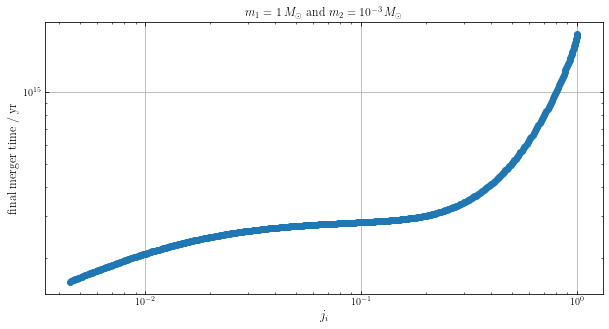

In [2]:
# Setting initial and final conditions of the binary evolution for an eccentric orbit
a_i_ref = a_initial * 1e11
e0_array = 1- np.geomspace(1e-5, 1, 400) 
e0_list = e0_array.tolist()





plt.figure(figsize = (10, 5))
plt.rc('lines', linewidth=1)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(which='both', right=True, top=True)





j0_ref3_list = np.zeros(len(e0_list))
tm_ref3_list = np.zeros(len(e0_list))


for k, e0 in enumerate (e0_list):
    m_bar = 1
    m1 =  m_bar * ms.solar_mass_to_pc  
    m2 = 1e-3 * ms.solar_mass_to_pc   
    D_luminosity = 5e8              
    ρ_bar = (ρ_eq/2) * (t_eq**(3/2)) * ((2 * G * m_bar)**(3/4))   
    r_spike = 1  # in parsecs, Choosen by choice
    alpha = 9/4
    rho_spike =  ρ_bar * (r_spike**(-alpha)) * ms.solar_mass_to_pc  
    spike = imripy.halo.Spike(rho_spike, r_spike, alpha)
    sp = ms.SystemProp(m1, m2, spike, D_luminosity)
    a_fin = sp.r_isco()      # Choosen equal to r_icso
    R_fin = sp.r_isco()      # The final condition for the evolution
    ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i_ref , e0,  a_fin = R_fin)
    tm_ref3_list[k] = ev_ecc.t[-1]/ms.year_to_pc
    j0_ref3_list[k] = np.sqrt(1 - (e0**2))
    np.save("tm3_ref",  tm_ref3_list)

plt.loglog(j0_ref3_list, tm_ref3_list, '--o')
    

print(tm_ref3_list)
    

plt.xlabel('$j_{i}$', fontsize = 13)
plt.ylabel('final merger time / yr', fontsize = 12)
plt.title('$m_{1} = 1 \, M_{\odot}$ and $m_{2}= 10^{-3} \,  M_{\odot}$ ')
plt.grid()
plt.show()

Evolving from  2.2342533717098506e+29  to  1.0 r_isco  with initial eccentricity 0.99999  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08


/home/pratibhajangra/imripy/src/imripy/inspiral.py:335: RuntimeWarning: invalid value encountered in sqrt
  v_s = np.sqrt(sp.m_total(a) *(2./r - 1./a))
/home/pratibhajangra/imripy/src/imripy/halo.py:321: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(r > self.r_min, self.rho_spike * (self.r_spike/r)**self.alpha, 0.)
/home/pratibhajangra/imripy/src/imripy/inspiral.py:337: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/home/pratibhajangra/imripy/src/imripy/inspiral.py:172: RuntimeWarning: invalid value encountered in double_scalars
  return -32./5. * sp.m_reduced(a)**2 * sp.m_total(a)**(5./2.) / a**(7./2.)  / (1. - e**2)**2 * (1. + 7./8.*e**2)
/home/pratibhajangra/imripy/src/imripy/inspiral.py:361: RuntimeWarning: invalid value encountered in sqrt
  retur

Required step size is less than spacing between numbers.
 -> Evolution took 3.6151s
Evolving from  2.2342533717098506e+29  to  1.0 r_isco  with initial eccentricity 0.9999897072522759  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 3.8673s
Evolving from  2.2342533717098506e+29  to  1.0 r_isco  with initial eccentricity 0.9999894059344289  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 4.0540s
Evolving from  2.2342533717098506e+29  to  1.0 r_isco  with initial eccentricity 0.9999890957955703  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 4.2957s
Evolving from  2.2342533717098506e+29  to  1.0 r_isco  with initial eccentricity 0.99998877657746

/home/pratibhajangra/imripy/src/imripy/inspiral.py:153: RuntimeWarning: invalid value encountered in double_scalars
  return -32./5. * sp.m_reduced(a)**2 * sp.m_total(a)**3 / a**5  / (1. - e**2)**(7./2.) * (1. + 73./24. * e**2 + 37./96. * e**4)
/home/pratibhajangra/imripy/src/imripy/inspiral.py:337: RuntimeWarning: invalid value encountered in double_scalars
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/home/pratibhajangra/imripy/src/imripy/inspiral.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total(a) * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]


Required step size is less than spacing between numbers.
 -> Evolution took 4.2420s
Evolving from  2.2342533717098506e+29  to  1.0 r_isco  with initial eccentricity 0.9998871162108315  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 4.4093s
Evolving from  2.2342533717098506e+29  to  1.0 r_isco  with initial eccentricity 0.9998838115635948  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 4.1253s
Evolving from  2.2342533717098506e+29  to  1.0 r_isco  with initial eccentricity 0.9998804101735626  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 4.1614s
Evolving from  2.2342533717098506e+29  to  1.0 r_isco  with initial eccentricity 0.99987690920861

/home/pratibhajangra/imripy/src/imripy/merger_system.py:202: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((self.mass(r) + self.m2)/r**3)


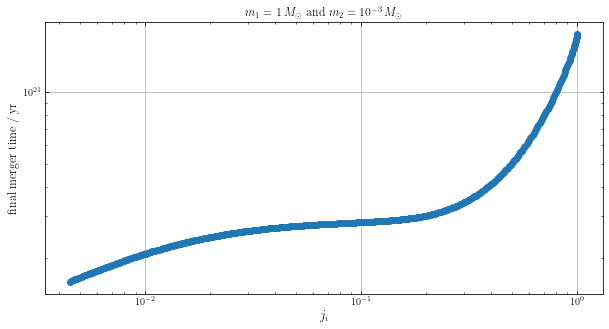

In [3]:
# Setting initial and final conditions of the binary evolution for an eccentric orbit
a_i_ref = a_initial * 1e19
e0_array = 1- np.geomspace(1e-5, 1, 400) 
e0_list = e0_array.tolist()





plt.figure(figsize = (10, 5))
plt.rc('lines', linewidth=1)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(which='both', right=True, top=True)





j0_ref4_list = np.zeros(len(e0_list))
tm_ref4_list = np.zeros(len(e0_list))


for k, e0 in enumerate (e0_list):
    m_bar = 1
    m1 =  m_bar * ms.solar_mass_to_pc  
    m2 = 1e-3 * ms.solar_mass_to_pc   
    D_luminosity = 5e8              
    ρ_bar = (ρ_eq/2) * (t_eq**(3/2)) * ((2 * G * m_bar)**(3/4))   
    r_spike = 1  # in parsecs, Choosen by choice
    alpha = 9/4
    rho_spike =  ρ_bar * (r_spike**(-alpha)) * ms.solar_mass_to_pc  
    spike = imripy.halo.Spike(rho_spike, r_spike, alpha)
    sp = ms.SystemProp(m1, m2, spike, D_luminosity)
    a_fin = sp.r_isco()      # Choosen equal to r_icso
    R_fin = sp.r_isco()      # The final condition for the evolution
    ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i_ref , e0,  a_fin = R_fin)
    tm_ref4_list[k] = ev_ecc.t[-1]/ms.year_to_pc
    j0_ref4_list[k] = np.sqrt(1 - (e0**2))
    np.save("tm4_ref",  tm_ref4_list)
    

plt.loglog(j0_ref4_list, tm_ref4_list, '--o')
    

print(tm_ref4_list)
    

plt.xlabel('$j_{i}$', fontsize = 13)
plt.ylabel('final merger time / yr', fontsize = 12)
plt.title('$m_{1} = 1 \, M_{\odot}$ and $m_{2}= 10^{-3} \,  M_{\odot}$ ')
plt.grid()
plt.show()

Evolving from  2.234253371709851  to  1.0 r_isco  with initial eccentricity 0.99999  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08


/home/pratibhajangra/imripy/src/imripy/inspiral.py:361: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total(a) * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]


A termination event occurred.
 -> Evolution took 0.9582s
Evolving from  2.234253371709851  to  1.0 r_isco  with initial eccentricity 0.9999897072522759  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 0.9939s
Evolving from  2.234253371709851  to  1.0 r_isco  with initial eccentricity 0.9999894059344289  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 1.0354s
Evolving from  2.234253371709851  to  1.0 r_isco  with initial eccentricity 0.9999890957955703  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08


/home/pratibhajangra/imripy/src/imripy/inspiral.py:361: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total(a) * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]


A termination event occurred.
 -> Evolution took 1.0267s
Evolving from  2.234253371709851  to  1.0 r_isco  with initial eccentricity 0.9999887765774673  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 1.0384s
Evolving from  2.234253371709851  to  1.0 r_isco  with initial eccentricity 0.9999884480143271  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 1.0252s
Evolving from  2.234253371709851  to  1.0 r_isco  with initial eccentricity 0.9999881098325756  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 1.0633s
Evolving from  2.234253371709851  to  1.0 r_isco  with initial eccentricity 0.9999877617506303  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Ev

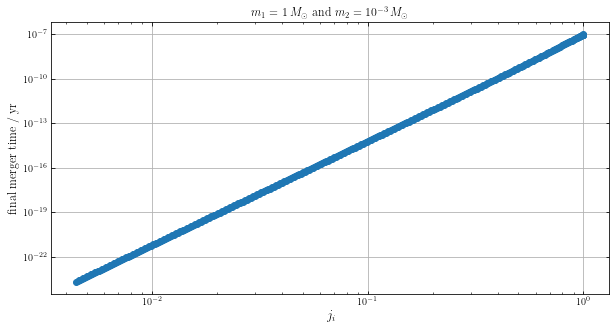

In [4]:

# Setting initial and final conditions of the binary evolution for an eccentric orbit
a_i_ref = a_initial * 1e-10
e0_array = 1- np.geomspace(1e-5, 1, 400) 
e0_list = e0_array.tolist()





plt.figure(figsize = (10, 5))
plt.rc('lines', linewidth=1)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(which='both', right=True, top=True)





j0_ref0_list = np.zeros(len(e0_list))
tm_ref0_list = np.zeros(len(e0_list))


for k, e0 in enumerate (e0_list):
    m_bar = 1
    m1 =  m_bar * ms.solar_mass_to_pc  
    m2 = 1e-3 * ms.solar_mass_to_pc   
    D_luminosity = 5e8              
    ρ_bar = (ρ_eq/2) * (t_eq**(3/2)) * ((2 * G * m_bar)**(3/4))   
    r_spike = 1  # in parsecs, Choosen by choice
    alpha = 9/4
    rho_spike =  ρ_bar * (r_spike**(-alpha)) * ms.solar_mass_to_pc  
    spike = imripy.halo.Spike(rho_spike, r_spike, alpha)
    sp = ms.SystemProp(m1, m2, spike, D_luminosity)
    a_fin = sp.r_isco()      # Choosen equal to r_icso
    R_fin = sp.r_isco()      # The final condition for the evolution
    ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i_ref , e0,  a_fin = R_fin)
    tm_ref0_list[k] = ev_ecc.t[-1]/ms.year_to_pc
    j0_ref0_list[k] = np.sqrt(1 - (e0**2))
    np.save("tm0_ref",  tm_ref0_list)
    

plt.loglog(j0_ref0_list, tm_ref0_list, '--o')
    

print(tm_ref0_list)
    

plt.xlabel('$j_{i}$', fontsize = 13)
plt.ylabel('final merger time / yr', fontsize = 12)
plt.title('$m_{1} = 1 \, M_{\odot}$ and $m_{2}= 10^{-3} \,  M_{\odot}$ ')
plt.grid()
plt.show()

In [16]:
tm_ref0_list = np.load('tm0_ref.npy')
tm_ref1_list = np.load('tm1_ref.npy')
tm_ref2_list = np.load('tm2_ref.npy')
tm_ref3_list = np.load('tm3_ref.npy')
tm_ref4_list = np.load('tm4_ref.npy')




j0_ref_list = np.load('j0_ref.npy')




tm_ref0_list = tm_ref0_list[-50:]
tm_ref1_list = tm_ref1_list[:100]
tm_ref2_list = tm_ref2_list[-100:]
tm_ref3_list = tm_ref3_list[-100:]
tm_ref4_list = tm_ref4_list[-50:]




tm_ref_list_1half = np.append(tm_ref0_list, tm_ref1_list)
tm_ref_list_2half = np.append(tm_ref2_list, tm_ref3_list)
tm_ref_1list = np.append(tm_ref_list_2half, tm_ref4_list)


tm_ref_list = np.append(tm_ref_list_1half, tm_ref_1list)


print(tm_ref_list)


np.savez("tmofj0", j0_ref_list, tm_ref_list)

[3.84298448e-09 4.21609139e-09 4.62353536e-09 5.06816575e-09
 5.55301659e-09 6.08130979e-09 6.65645677e-09 7.28205858e-09
 7.96190124e-09 8.69995069e-09 9.50034562e-09 1.03673817e-08
 1.13054965e-08 1.23192491e-08 1.34132905e-08 1.45923344e-08
 1.58611132e-08 1.72243311e-08 1.86866152e-08 2.02524463e-08
 2.19260906e-08 2.37115098e-08 2.56122742e-08 2.76314478e-08
 2.97714711e-08 3.20340286e-08 3.44198894e-08 3.69287547e-08
 3.95590551e-08 4.23077618e-08 4.51701704e-08 4.81396648e-08
 5.12074738e-08 5.43623933e-08 5.75905373e-08 6.08750689e-08
 6.41959253e-08 6.75295646e-08 7.08487348e-08 7.41223024e-08
 7.73151026e-08 8.03878815e-08 8.32973287e-08 8.59962419e-08
 8.84338351e-08 9.05562241e-08 9.23071216e-08 9.36287721e-08
 9.44631534e-08 9.47534665e-08 5.02351195e+06 5.05135674e+06
 5.07925131e+06 5.10719398e+06 5.13518213e+06 5.16321458e+06
 5.19128909e+06 5.21940372e+06 5.24755594e+06 5.27574428e+06
 5.30396650e+06 5.33222042e+06 5.36050385e+06 5.38881461e+06
 5.41715049e+06 5.445509